# Content
- Introduction
- Scatter plots and correlation
- Regression
    - Simple Linear Regression
    - Coefficient of Determination and Standard Error of the Estimate
    - Multiple Linear Regression
    - Logistic Regression

In [16]:
# Imports
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import OLS
from statsmodels.api import add_constant
import numpy as np
import pandas as pd
import math
import pylab
import seaborn as sns

In [129]:
# Generic functions

def preferred_rounding(v, decimals=2):
    return str(round(v, decimals))

def display_probability_density_chart(
    cv_left=None,
    cv_right=None,
    test_value=None,
):
    r'''
    Display probability density chart.
    '''  
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    
    # Standard normal distribution curve
    x = np.linspace(
        stats.norm.ppf(0.001),
        stats.norm.ppf(0.999), 
        100
    )
    curve = stats.norm.pdf(x)
        
    ax.plot(
        x, 
        curve,
        'r-', 
        color='#000000',
        lw=3, 
        alpha=0.8,
        label='Standard normal distribution curve'
    )
    
    # Critical region(s) in chart
    if cv_left:
        critical_region_left = np.linspace(-3.1, cv_left, 100)
        ax.fill_between(
            critical_region_left, 
            stats.norm.pdf(critical_region_left), 
            color='#f4c242', 
            alpha=0.5,
        )
        critical_value_left = np.linspace(cv_left-0.01, cv_left+0.01, 100)
        ax.fill_between(
            critical_value_left, 
            stats.norm.pdf(critical_value_left), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_left)
        )
        
    if cv_right:
        critical_region_right = np.linspace(cv_right, 3.1, 100)
        critical_value_right = np.linspace(cv_right-0.01, cv_right+0.01, 100)
        ax.fill_between(
            critical_value_right, 
            stats.norm.pdf(critical_value_right), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_right)
        )
        ax.fill_between(
            critical_region_right, 
            stats.norm.pdf(critical_region_right), 
            color='#f4c242', 
            alpha=0.5,
        )
       
    # Test value
    if test_value:
        ax.axvline(
            x=test_value, 
            linewidth=1.5, 
            color='#ff6666',
        )
        ax.text(
            x=test_value+.1, 
            y=0.2, 
            s='test value =' + preferred_rounding(test_value), 
            rotation=90,
        )
        
    ax.legend()
    plt.show()
    

def get_zscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)    
):
    r'''
    Calculate z-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.norm.ppf(p_left)
        
    elif p_right and not p_left:
        test_value = 1 - stats.norm.ppf(p_right)
    
    elif p_left and p_right:
        test_value_left = stats.norm.ppf(p_left)
        test_value_right = stats.norm.ppf(p_right)
        test_value = test_value_right - test_value_left
    
    return test_value


def get_fscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)
    dfn=None,
    dfd=None,
):
    r'''
    Calculate t-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.f.ppf(p_left, dfn, dfd)
        
    elif p_right and not p_left:
        test_value = 1 - stats.f.ppf(p_right, dfn, dfd)
    
    elif p_left and p_right:
        test_value_left = stats.f.ppf(p_left, dfn, dfd)
        test_value_right = stats.f.ppf(p_right, dfn, dfd)
        test_value = test_value_right - test_value_left
    
    return test_value

# Introduction

## Area of inferential statistics

We want to determine whether a relationship exists between 2 or more quantitative (numerical) variables.

We want to answer 4 questions **statistically**:
1. Are 2 or more variables **linearly related**? Use the correlation coefficient.
2. If so, what is the strength of the relationship? Use the correlation coefficient.
3. What type of relationship exists (simple or multiple)?
4. What kind of prediction can be made from this relationship?

## Applications

Examples:
- Sales volume relates to ad expenses.
- Number of hours student studied relates to exams score.

## Definitions

- **Correlation:** statistical method used to determine whether linear relationship exists between variables.
- **Regression:** statistical method used to determine nature of relationship between variables. Can be positive or negative, linear or nonlinear. 

# Scatter Plots

It is not always easy to know which variable is x and y.

## Definitions
- **Independent variable:** explanatory variable/predictor used to predict the value of a dependent variable. Can be 1 or more and anotation is x.
- **Dependent variable:** response variable that cannot be controlled or manipulated. Must be 1 and anotation is y. 
- **Scatter plot:** graph consisting of independent variable x and dependent variable y.

## Implementation

In [3]:
def display_scatter_plot(df, x, y, c=None):
    if c:        
        ax = df.plot.scatter(
            x=x, 
            y=y,
            c=c,
            colormap='viridis'
        )        
    else:
        ax = df.plot.scatter(
            x=x, 
            y=y,
        )
    
    max_x = df.loc[df[x].idxmax()][x]
    max_y = df.loc[df[y].idxmax()][y]
    ax.set_xlim(0, np.ceil(max_x*1.1))
    ax.set_ylim(0, np.ceil(max_y*1.1))

## Examples

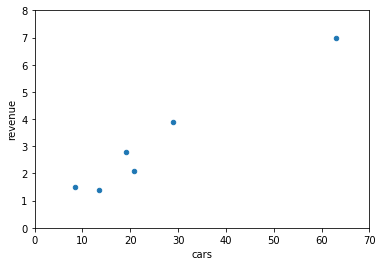

In [4]:
# Car sales
df_car_sales = pd.DataFrame({
    'company': list('ABCDEF'),
    'cars' : [63, 29, 20.8, 19.1, 13.4, 8.5],
    'revenue': [7, 3.9, 2.1, 2.8, 1.4, 1.5],
})

display_scatter_plot(df_car_sales, 'cars', 'revenue')

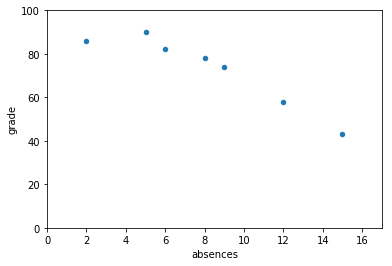

In [5]:
# Absences and grade
df_absences = pd.DataFrame({
    'student': list('ABCDEFG'),
    'absences' : [6, 2, 15, 9, 12, 5, 8],
    'grade': [82, 86, 43, 74, 58, 90, 78],
})
display_scatter_plot(df_absences, 'absences', 'grade')

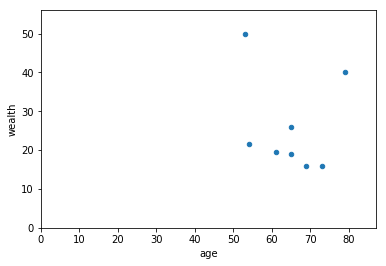

In [6]:
# Age and wealth
df_wealth = pd.DataFrame({
    'person': list('ABCDEFGH'),
    'age' : [73, 65, 53, 54, 79, 69, 61, 65],
    'wealth': [16, 26, 50, 21.5, 40, 16, 19.6, 19],
})
display_scatter_plot(df_wealth, 'age', 'wealth')

# Correlation

## Definitions

- **Correlation coefficient:** measures the strength and direction of a linear relationsip between 2 quantitative variables. Annotation:
    - **r** = sample correlation coefficient
    - **ρ** = population correlation coefficient
    
Here we focus on **PPMC** (Pearson product-moment correlation coefficient). 

**-1 ≤ PPMC ≤ 1**

Here which variable is x and which variable y doesn't matter!


## Formulas

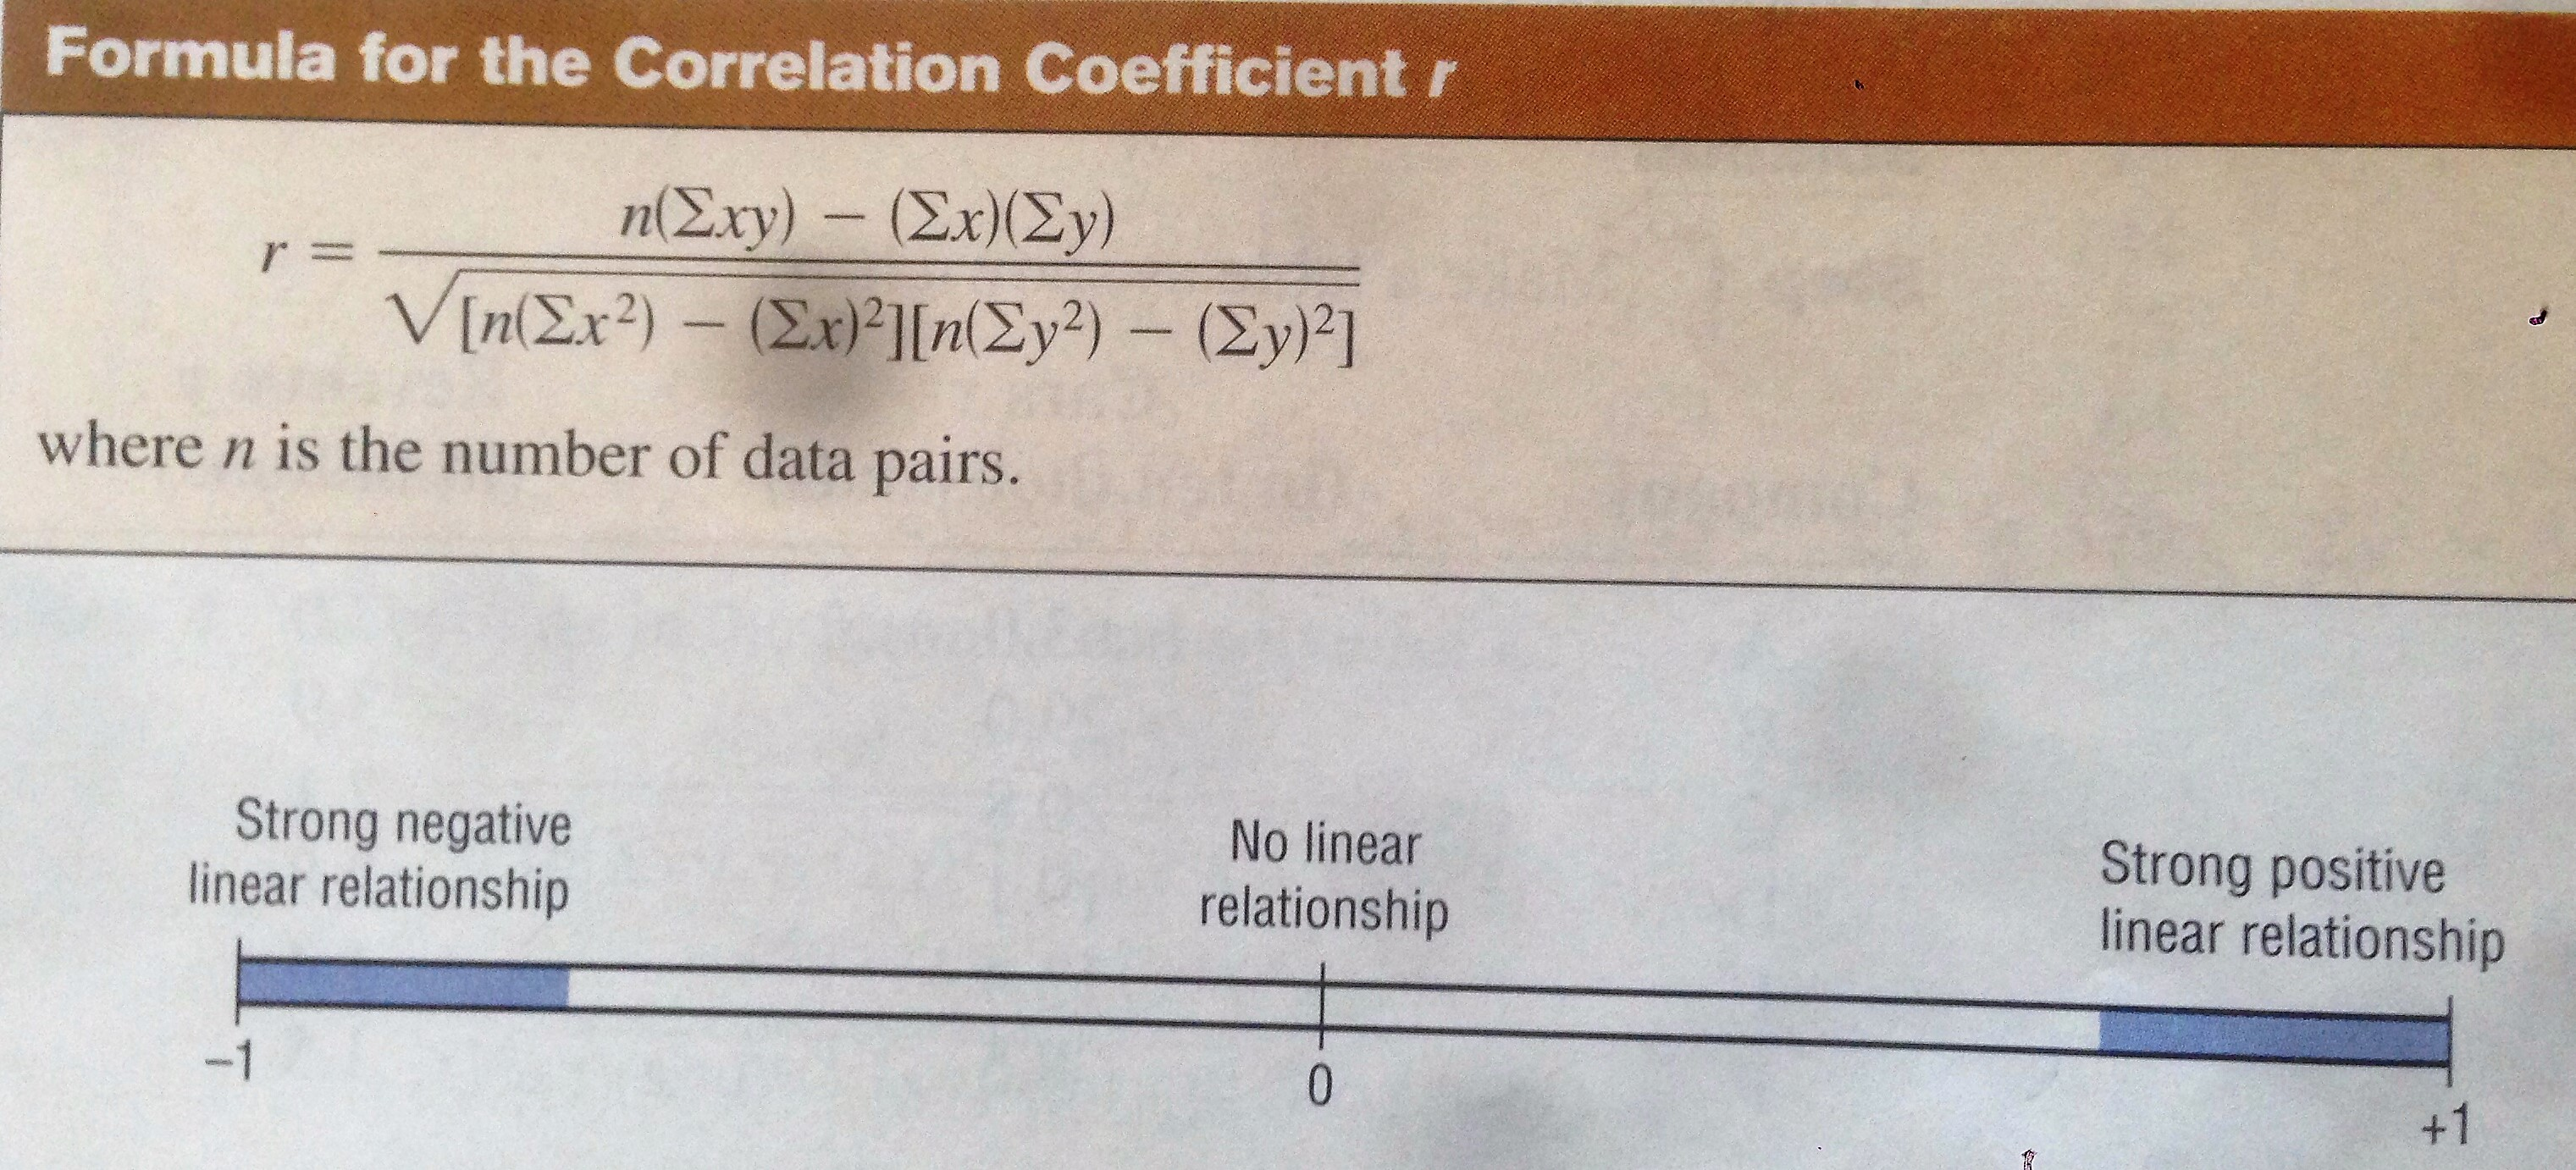

## Implementation

In [7]:
def compute_correlation_coefficient(df, x, y):
    r'''
    Compute PPMC
    '''
    lr = stats.linregress(df[x], df[y])
    return lr.rvalue

## Examples

In [8]:
# Car sales
df_car_sales = pd.DataFrame({
    'company': list('ABCDEF'),
    'cars' : [63, 29, 20.8, 19.1, 13.4, 8.5],
    'revenue': [7, 3.9, 2.1, 2.8, 1.4, 1.5],
})
ppmc = compute_correlation_coefficient(df_car_sales, 'cars', 'revenue')
print('PPMC =', preferred_rounding(ppmc, 3))

PPMC = 0.982


In [9]:
# Absences and grade
df_absences = pd.DataFrame({
    'student': list('ABCDEFG'),
    'absences' : [6, 2, 15, 9, 12, 5, 8],
    'grade': [82, 86, 43, 74, 58, 90, 78],
})
ppmc = compute_correlation_coefficient(df_absences, 'absences', 'grade')
print('PPMC =', preferred_rounding(ppmc, 3))

PPMC = -0.944


# Relationship between correlation coefficient and scatter plot

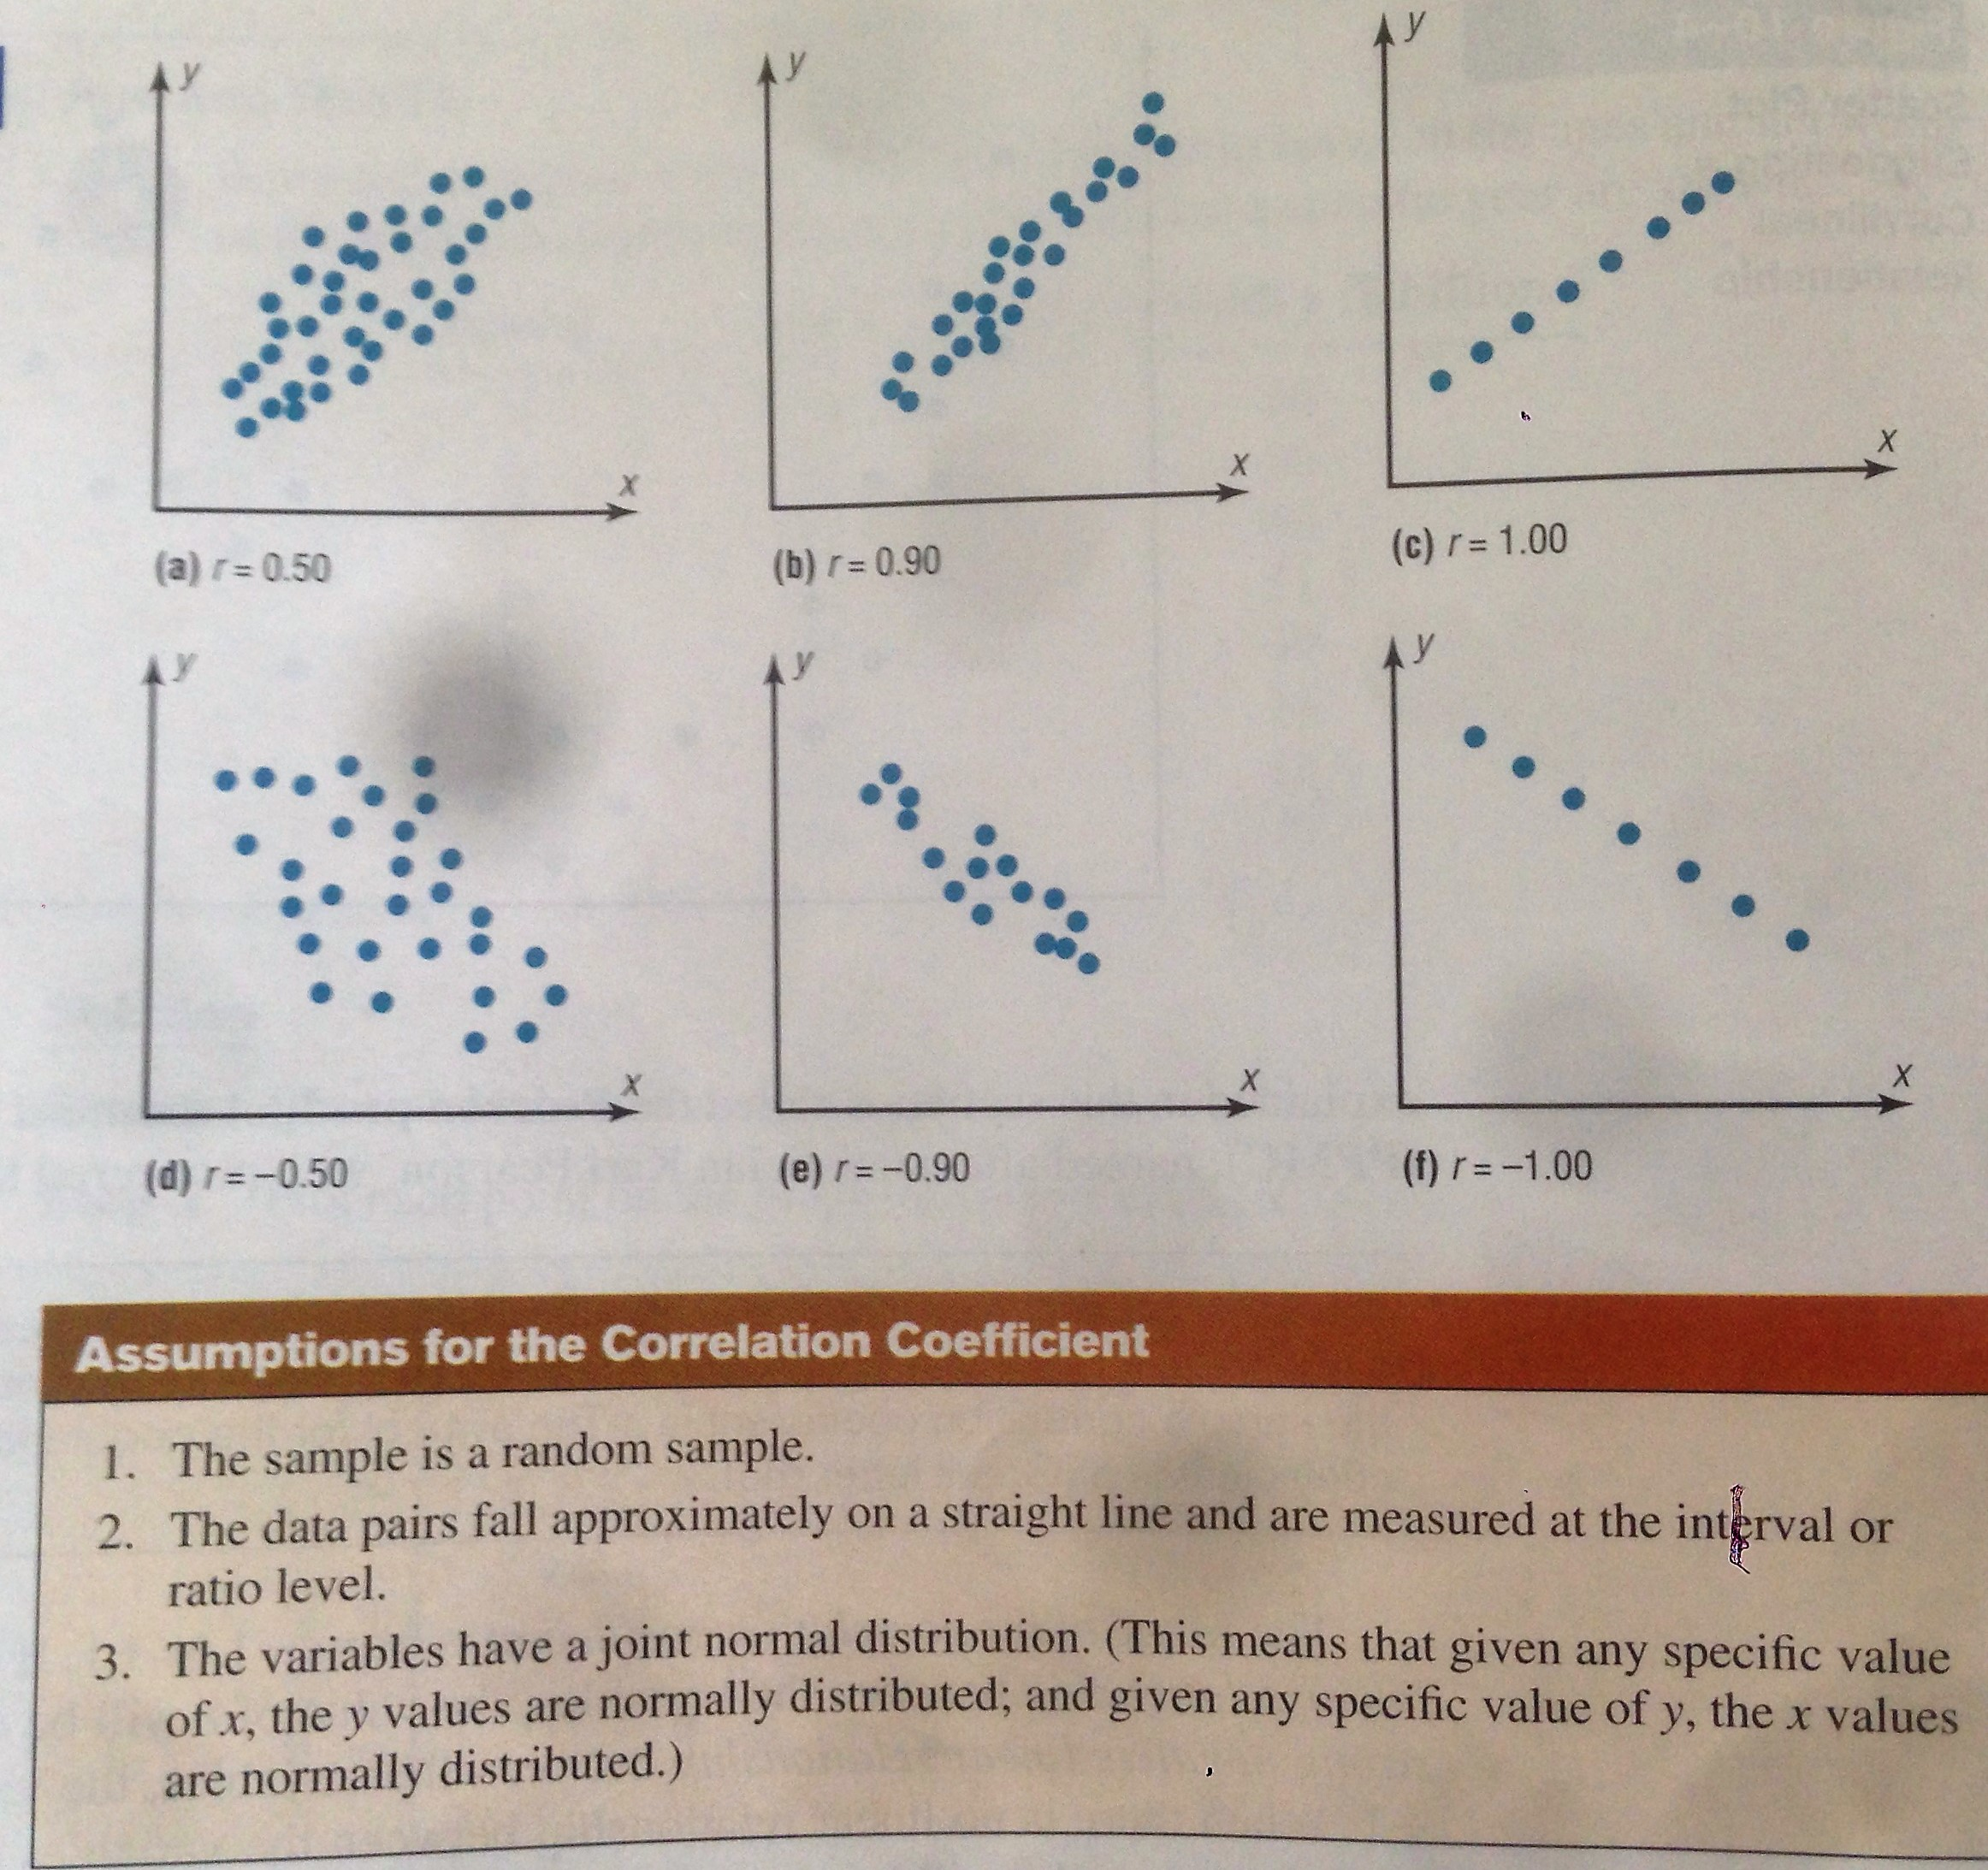

# Significance of the correlation coefficient

Is the value of r statistically significant or due to chance?

Because we are comparing sample to population we can do **hypothesis testing**. And we use a t test.

## Format

H0: ρ = 0 => no correlation between x and y variables in the population.
H1: ρ ≠ 0 => significant correlation between variabls in the population.

There is **no need to identify the claim** as we just want to know if there is a significant linear relationship between variables.

## Formula

t = r √ df/(1-r²)

df = n -2

## Implementation

In [10]:
def compute_hypothesis_test_for_correlation_coefficient(
    n,
    r,
    significance_level=.05,
    ddof=2,
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test to validate the relationship between x and y (validate the correlation coefficient).
    Test is always two-tailed
    """
     
    df = n-ddof # degree of freedom
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')

    # Statement
    h0 = 'H0: ρ = 0'
    h1 = 'H1: ρ ≠ 0'  
    print(h0, 'and', h1)
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level/2
    cv_right = abs(get_tscore_from_probability(p_left=tailed_alpha, df=df))
    cv_left = -cv_right
    print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')

    
    # 3. Test value, P-value and chart
    print()
    print('3. Test value, P-value and chart')
    
    # Hypothesis test for a correlation coefficient

    print('Test type: t test')
    standard_error = 1-np.power(r, 2)
    test_value = r * np.sqrt(df/standard_error) 

    # Calculate P-value
    p_value = stats.t.sf(abs(test_value), df=df) 
    p_value = p_value*2 
    print('test value = ', preferred_rounding(test_value))
    print('P-value = ', preferred_rounding(p_value, 4))
    
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4a. Result and decision (traditional method)
    print()
    print('4a. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'there is a significant relationship between x and y'
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although ' + claim + ', there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the relationship between x and y is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')
        

    # 4b. Result and decision (P-value method)
    print()
    print('4b. Result and decision (P-value method)')
    if p_value <= tailed_alpha:
        decision_statement_p_value_method = 'reject'
        print('P-value ≤ ∝, therefore we reject H0.')
    else:
        decision_statement_p_value_method = 'not reject'
        print('P-value > ∝, therefore we do NOT reject H0.')  
        
    # 5. Summary
    print()
    print('5. Summary')
    if decision_statement == decision_statement_p_value_method:
        print('The traditional method and P-value method support the same conclusion.')
    else:
        print('The traditional method and P-value method do NOT support the same conclusion.')

## Examples


1. Hypothesis
H0: ρ = 0 and H1: ρ ≠ 0

2. Critical value(s)
C.V. = ±2.78 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  10.39
P-value =  0.0005


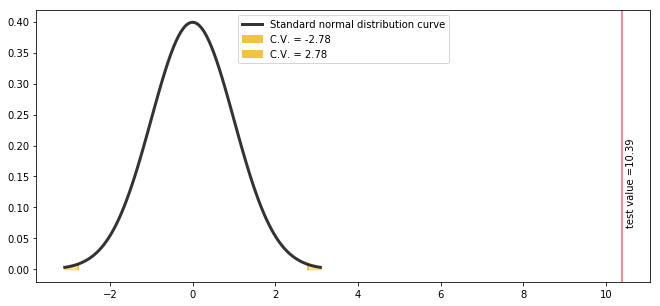


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that there is a significant relationship between x and y with a significance level of 0.05.

Although there is a significant relationship between x and y, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [11]:
df_car_sales = pd.DataFrame({
    'company': list('ABCDEF'),
    'cars' : [63, 29, 20.8, 19.1, 13.4, 8.5],
    'revenue': [7, 3.9, 2.1, 2.8, 1.4, 1.5],
})
ppmc = compute_correlation_coefficient(df_car_sales, 'cars', 'revenue')

hypothesis_test = compute_hypothesis_test_for_correlation_coefficient(
    n=6,
    r=ppmc,
    significance_level=.05,
    ddof=2,
    show_chart=True,
)

p_value: 0.6761681616676287

1. Hypothesis
H0: ρ = 0 and H1: ρ ≠ 0

2. Critical value(s)
C.V. = ±3.71 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  -0.44
P-value =  0.6762


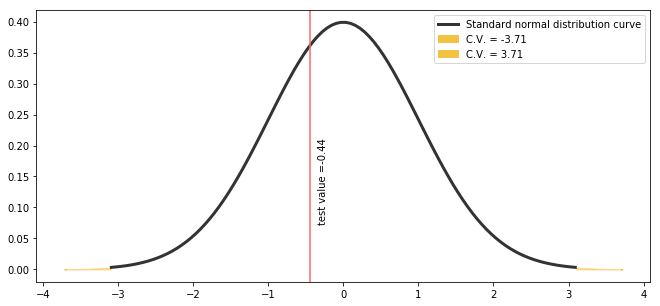


4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that there is a significant relationship between x and y with a significance level of 0.01.

Although the relationship between x and y is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error

4b. Result and decision (P-value method)
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [12]:
# Age and wealth
df_wealth = pd.DataFrame({
    'person': list('ABCDEFGH'),
    'age' : [73, 65, 53, 54, 79, 69, 61, 65],
    'wealth': [16, 26, 50, 21.5, 40, 16, 19.6, 19],
})
ppmc = compute_correlation_coefficient(df_wealth, 'age', 'wealth')
n = len(df_wealth['age'])
p_value = stats.linregress(df_wealth['age'], df_wealth['wealth']).pvalue
print('p_value:', p_value)

hypothesis_test = compute_hypothesis_test_for_correlation_coefficient(
    n=n,
    r=ppmc,
    significance_level=.01,
    ddof=2,
    show_chart=True,
)

ppmc = 0.9657924599739434

1. Hypothesis
H0: ρ = 0 and H1: ρ ≠ 0

2. Critical value(s)
C.V. = ±2.78 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  7.45
P-value =  0.0017


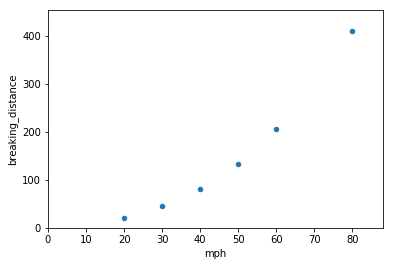

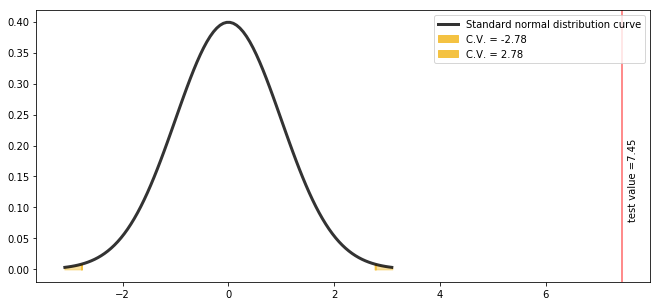


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that there is a significant relationship between x and y with a significance level of 0.05.

Although there is a significant relationship between x and y, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [13]:
# Breaking distance
df_traffic = pd.DataFrame({
    'mph' : [20, 30, 40, 50, 60, 80],
    'breaking_distance': [20, 45, 81, 133, 205, 411],
})
ppmc = compute_correlation_coefficient(df_traffic, 'mph', 'breaking_distance')
n = len(df_traffic['breaking_distance'])

print('ppmc =', ppmc)
display_scatter_plot(df_traffic, 'mph', 'breaking_distance')

hypothesis_test = compute_hypothesis_test_for_correlation_coefficient(
    n=n,
    r=ppmc,
    significance_level=.05,
    ddof=2,
    show_chart=True,
)

# Regression

## Simple Linear Regression

### Concept Questions

1. **Which measure used for knowing that x and y moving in same direction?** correlation coefficient
2. **Which number measures the distance from prediction line to the actual values?** The unexplained variation Σ(y - y')²
3. **Which number is the slope of the regression line?** a, as in y' = ax + b
4. **Which number is the y intercept of the regression line??** b, as in y' = ax + b
5. **Which number can be found in a table?** critical value
6. **Which number is the allowable risk of making a type I error?** Type I means rejecting a true null hypothesis. Allowable risk controlled with level of significance (e.g. 0.10)
7. **Which number measures the variation explained by the regression?** coefficient of determination
8. **Which number measures the scatter of points about the regression line?** standard error of the estimate
9. **What is the null hypothesis? H0: ρ = 0
10. **Which number is compared to the critical value to see if the null hypothesis should be rejected?** Test statistic


### Objective
Study of relationship between 2 variables:
1. Draw scatter plot to determine teh nature of the relationship
2. Compute correlation coefficient
3. Test significance of the relationship
4. Determine the equation of the regression line (data line of best fit)

**Important:** if r not significant, then regression line and prediction will be misleading.

### Determination of regression line equation

y' = a + bx

a = y' intercept; b = slope of the line

### Implementation

In [14]:
tips = sns.load_dataset("tips")
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [15]:
def display_regression_line(df, x, y):
    
    # Equation
    found_y, equation = get_y_from_equation_of_regression_line(df, x, y)

    # Plot
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    ax.set_title(equation)
    fig.set_size_inches(13, 6)
    sns.regplot(x=x, y=y, data=df, ax=ax)
    sns.despine()
    
    
def get_y_from_equation_of_regression_line(df, x, y, asked_x=0):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
    found_y = slope*asked_x+intercept
    equation = 'y={:.2f}x+{:.2f}'.format(slope, intercept)
    
    return found_y, equation    

### Examples

x = 20; y = 2.52


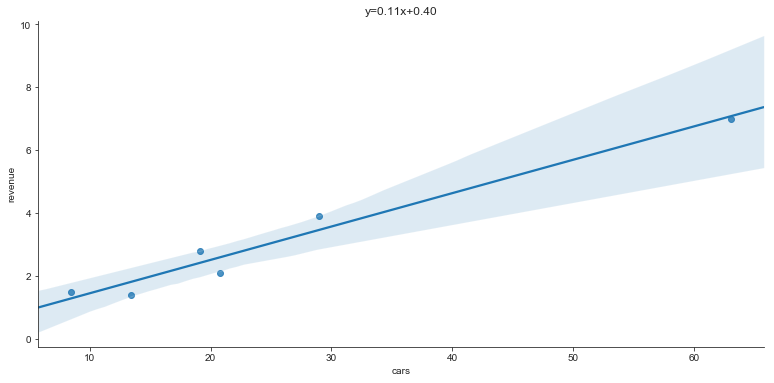

In [16]:
# Car sales
df_car_sales = pd.DataFrame({
    'company': list('ABCDEF'),
    'cars' : [63, 29, 20.8, 19.1, 13.4, 8.5],
    'revenue': [7, 3.9, 2.1, 2.8, 1.4, 1.5],
})

display_regression_line(df_car_sales, 'cars', 'revenue')
found_y, equation = get_y_from_equation_of_regression_line(df_car_sales, 'cars', 'revenue', asked_x=20)
print('x = 20; y =', preferred_rounding(found_y, decimals=2))

x = 45 ; y = 138.41
x = 100 ; y = 493.24


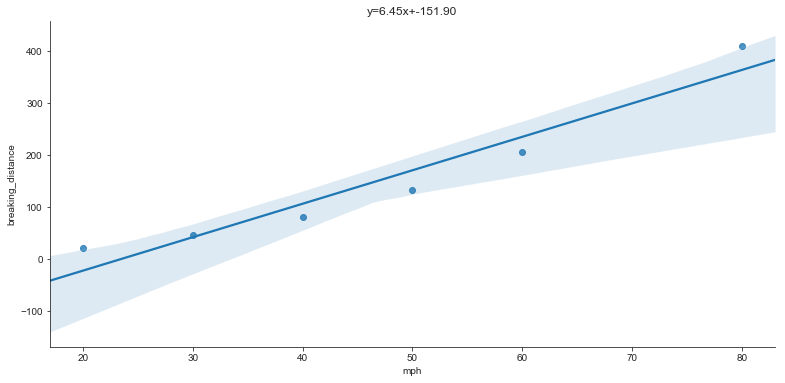

In [17]:
# Breaking distance
df_traffic = pd.DataFrame({
    'mph' : [20, 30, 40, 50, 60, 80],
    'breaking_distance': [20, 45, 81, 133, 205, 411],
})
display_regression_line(df_traffic, 'mph', 'breaking_distance')

asked_x = 45
found_y, equation = get_y_from_equation_of_regression_line(df_traffic, 'mph', 'breaking_distance', asked_x=asked_x)
print('x =', asked_x, '; y =', preferred_rounding(found_y, decimals=2))

asked_x = 100
found_y, equation = get_y_from_equation_of_regression_line(df_traffic, 'mph', 'breaking_distance', asked_x=asked_x)
print('x =', asked_x, '; y =', preferred_rounding(found_y, decimals=2))

### Notes

Be careful about **influential points** (outliers that tend to "pull" the regression line toward them).

Solution, graph 2 regression lines:
- With outliers
- Without outliers

Check if large difference.

**Extrapolations outside the data range are risky because we know nothing about the relationship of the data outside the range**.

### Types of variations for the regression model

Here we compare observed values to predicted values.

**Total variation** = explained variation + unexplained variation

Σ(y - ȳ)² = Σ(y' - ȳ)² + Σ(y - y')²

**Residual** = y - y' => the result can be plot in a residual plot with mean always 0

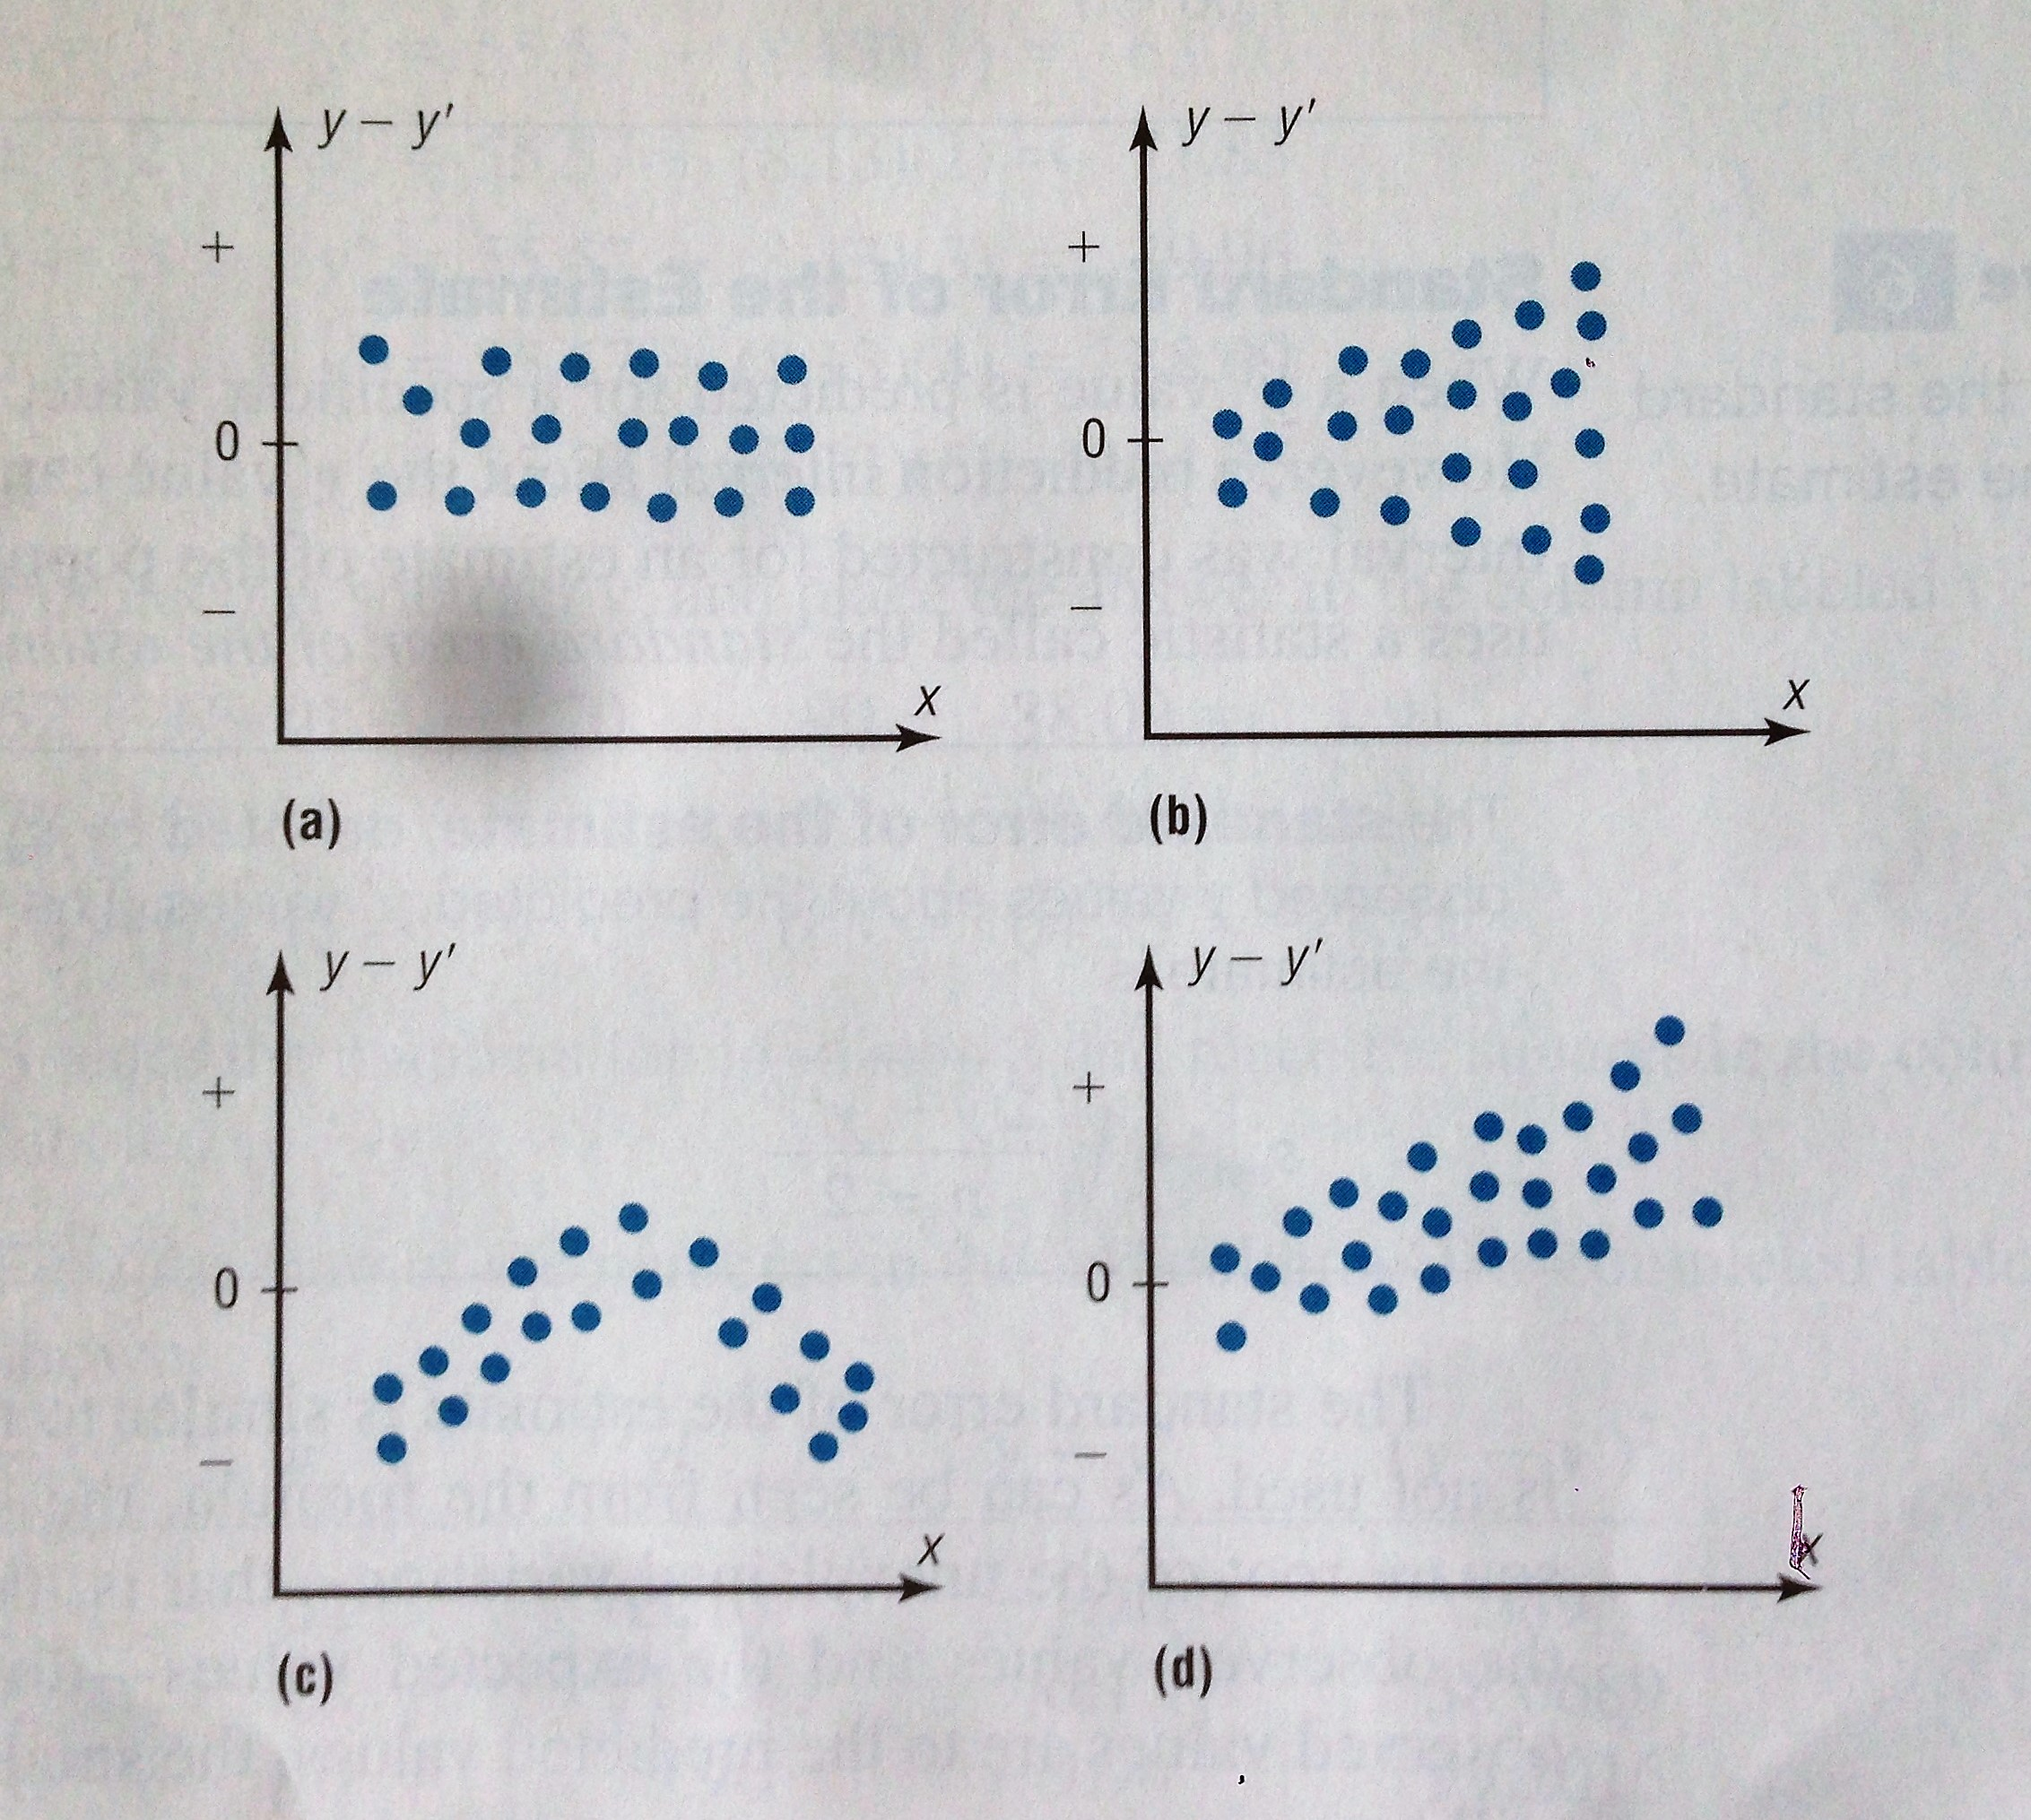

If residual values are somehow evenly distributed about the line, then the relationship between x and y is linear and regression line can be used for the regression.

### Coefficient of Determination

r² = explained variation/total variation, expressed as %

It is the result of r square, where r is the correlation coefficient.

#### Definition
**Coefficient of determination:** Measure of variation of the dependent variable (y) that is explained by the regression line and the independent variable (x).

E.g. r²=81% means that 81% of the variation in the dependent variable is accounted for (is explained) by the variation in the independent variable. The remaining 19% of the variation are unexplained.

**Coefficient of undetermination:** 1-r²

#### Implementation

In [18]:
def compute_coefficient_of_determination(df, x, y):
    r'''
    Compute coefficient of determination (r²)
    '''    
    return np.power(compute_correlation_coefficient(df, x, y), 2)

### Standard Error of the Estimate

#### Definition
**Goal is to construct the prediction interval**, which uses the standard error of estimate.

The closer the observed values to the predicted values, the smaller the standard error of the estimate

#### Formula

Sest = √[Σ(y - y')²)/(n-2)]

#### Implementation

In [55]:
def compute_standard_error_estimate(df, x, y, ddof=2):
    r'''
    Compute standard error of the estimate
    '''
    assert len(df[x]) == len(df[y])
    
    lr = stats.linregress(df[x], df[y])
    a = lr.intercept
    b = lr.slope
    
    sum_y_square = np.sum(df[y]**2)
    sum_y = np.sum(df[y])
    sum_xy = np.sum(np.multiply(df[x], df[y]))
    n = len(df[x])    
    
    sest = np.sqrt((sum_y_square-a*sum_y-b*sum_xy)/(n-ddof))
    return sest

In [57]:
# Machine maintenance
df_machine_maintenance = pd.DataFrame({
    'machine': list('ABCDEF'),
    'years' : [1, 2, 3, 4, 4, 6],
    'costs': [62, 78, 70, 90, 93, 103],
})
sest = compute_standard_error_estimate(df_machine_maintenance, 'years', 'costs')
print('Sest =', preferred_rounding(sest, 3))

Sest = 6.514


## Multiple Regression

### Regression

Here we have several independent variables x and one dependent variable y.

#### Assumptions

Independent variables should not be correlated (such as components of formula).

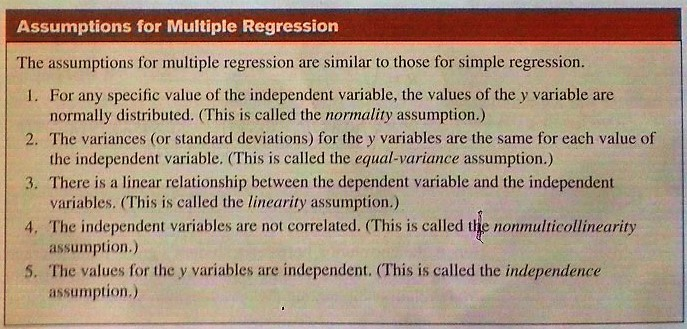

#### Formula

y' = a + b1x1 + b2x2 + ... + bkxk

b's are called partial regression coefficients.

#### Implementation

OLS: ordinary least squares is a type of linear least squares method for estimating the unknown parameters in a linear regression model.

In [97]:
def generate_multiple_linear_regression_model(df, y, **kwargs):
    r'''
    Compute multiple linear regression and relevant coefficients.
    '''
    
    # Get independent variable values
    x_list = list()
    for k, v in kwargs.items():
        assert k[0] == 'x' and k[1:].isdigit()
        x_list.append(v)
        
    transposed_x_list = add_constant(df[x_list].values)
    return OLS(endog=df[y], exog=transposed_x_list).fit()


def make_prediction(model, **kwargs):
    r'''
    Compute prediction.
    '''
    
    # Get independent variable values
    x_list = list()
    for k, v in kwargs.items():
        assert k[0] == 'x' and k[1:].isdigit()
        x_list.append(v)
    
    # Add constant
    x_list.insert(0, 1.)
    
    # Predict
    return model.predict(x_list)[0]

#### Test

In [103]:
# Student test grades depending on age and GPA
df_student_grades = pd.DataFrame({
    'score': [550, 570, 525, 670, 490],
    'gpa': [3.2, 2.7, 2.5, 3.4, 2.2],
    'age': [22, 27, 24, 28, 23],
})
model = generate_multiple_linear_regression_model(
    df=df_student_grades,
    y='score',
    x1='gpa',
    x2='age',
)
prediction = make_prediction(model, x1=3.0, x2=25)
prediction

581.4346252317457

In [104]:
# Boston house
df_boston_house = pd.DataFrame({
    'y':  [1,2,3,4,3,4,5,4,5,5,4,5,4,5,4,5,6,5,4,5,4,3,4],
    'x1': [4,2,3,4,5,4,5,6,7,4,8,9,8,8,6,6,5,5,5,5,5,5,5],
    'x2': [4,1,2,3,4,5,6,7,5,8,7,8,7,8,7,8,7,7,7,7,7,6,5],
    'x3': [4,1,2,5,6,7,8,9,7,8,7,8,7,7,7,7,7,7,6,6,4,4,4],
})
model = generate_multiple_linear_regression_model(
    df=df_boston_house,    
    y='y',
    x1='x1',
    x2='x2',
    x3='x3',
)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     7.281
Date:                Sun, 25 Nov 2018   Prob (F-statistic):            0.00191
Time:                        08:04:42   Log-Likelihood:                -26.025
No. Observations:                  23   AIC:                             60.05
Df Residuals:                      19   BIC:                             64.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5704      0.633      2.481      0.023       0.245       2.895
x1            -0.0618      0.145     -0.427      0.674      -0.365       0.241
x2             0.2360      0.149      1.587      0.129      -0.075       0.547
x3             0.2424      0.139      1.739      0.098      -0.049       0.534
==============================================================================
Omnibus:                        6.904   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                4.708
Skew:                          -0.849   Prob(JB):                       0.0950
Kurtosis:                       4.426   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### R

#### Definition
R is the **multiple regression correlation coefficient** to determine if a significant relationship exists between independent and dependent variables. 

**0 ≤ R ≤ 1**, the closer R is to 1, the stronger the relationship.

#### Formula

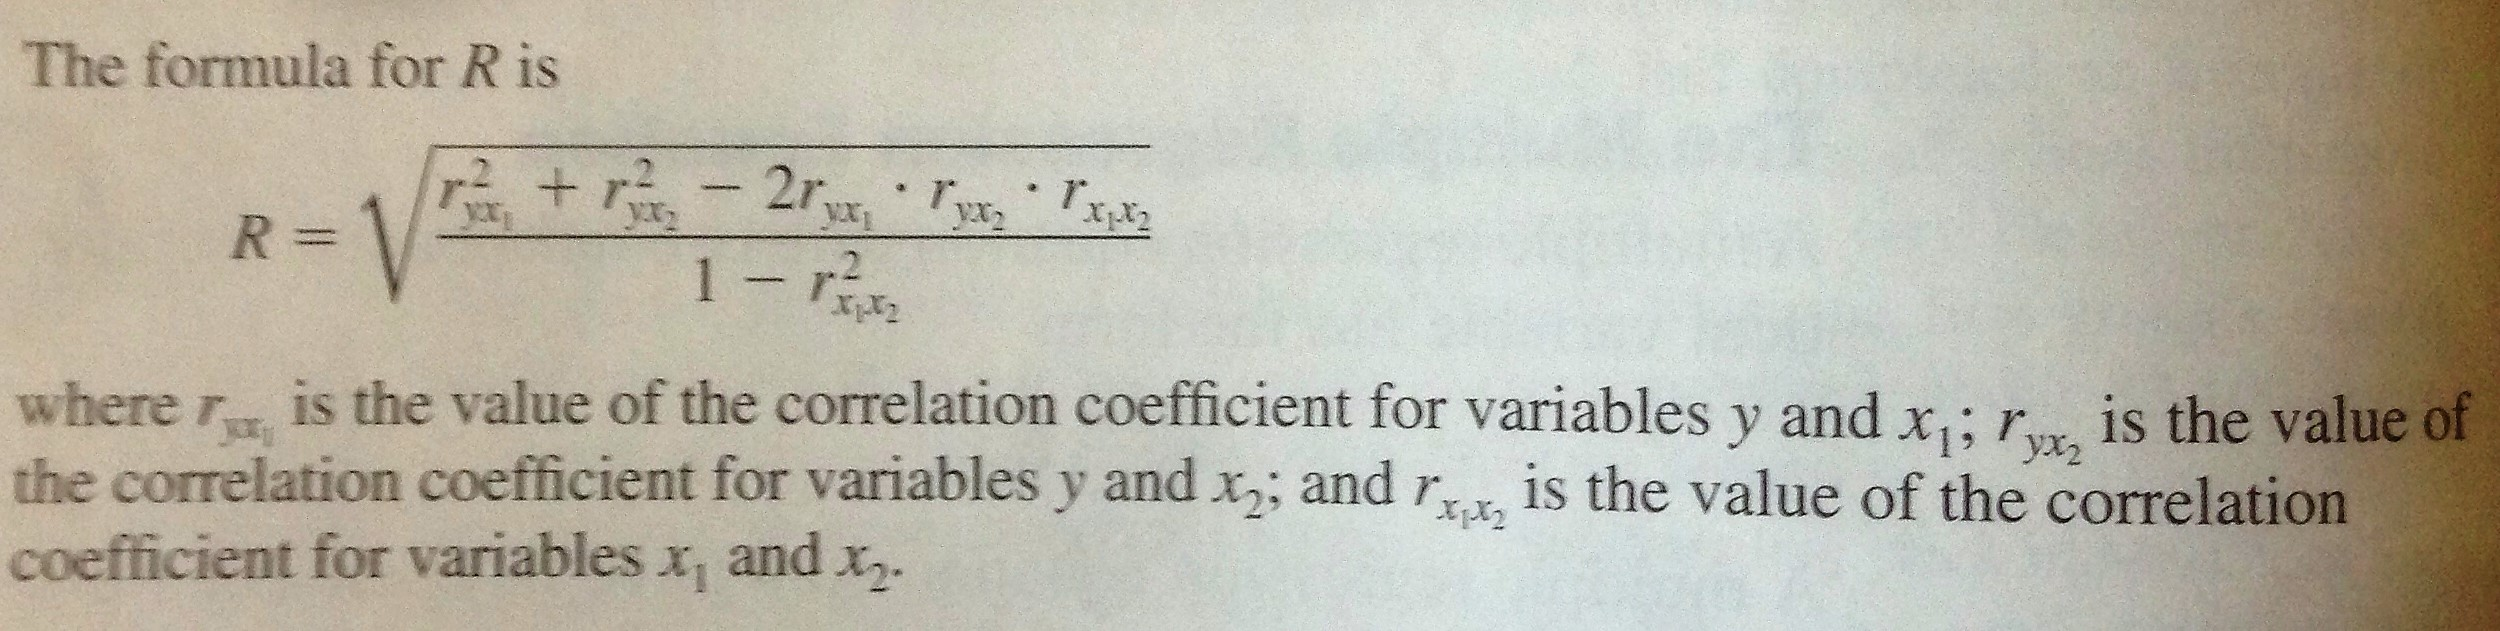

#### Implementation

In [105]:
def calculate_rsquared(model):
    r'''
    Compute R squared.
    '''
    return model.rsquared


def calculate_r(model):
    r'''
    Compute R.
    '''
    return np.sqrt(calculate_rsquared(model))

#### Examples

In [106]:
model = generate_multiple_linear_regression_model(
    df=df_student_grades,
    y='score',
    x1='gpa',
    x2='age',
)
print('R² =', calculate_rsquared(model))
print('R =', calculate_r(model))

R² = 0.9786911482532823
R = 0.9892882028273067


### Testing significance of R

Use the F test with hypothesis: H0: ρ = 0; H1: ρ ≠ 0

#### Formula

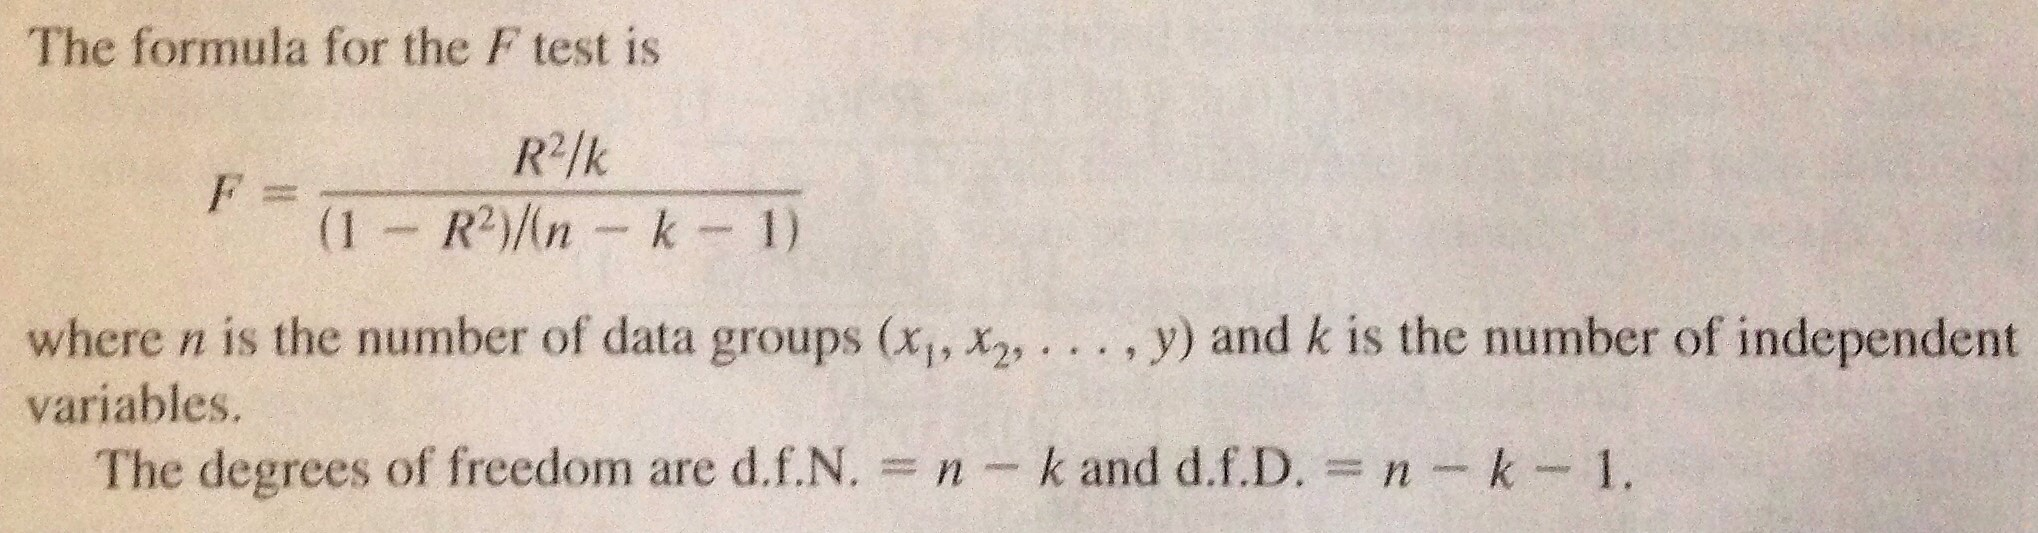

#### Implementation

In [130]:
def calculate_ftest(model):
    r'''
    Compute F-statistic.
    '''
    return model.fvalue


def compute_hypothesis_test_for_correlation_coefficient_multiple(
    model,
    n,
    k, # number of independent variables
    significance_level=.05,
    ddof=1,
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test to validate the multiple correlation coefficient.
    Test is always two-tailed
    """
     
    dfn = n-k # degrees of freedom numerator
    dfd = dfn-ddof # degree of freedom denominator
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')

    # Statement
    h0 = 'H0: ρ = 0'
    h1 = 'H1: ρ ≠ 0'  
    print(h0, 'and', h1)
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level/2
    cv_right = abs(get_fscore_from_probability(p_left=tailed_alpha, dfn=dfn, dfd=dfd))
    cv_left = -cv_right
    print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')

    
    # 3. Test value, P-value and chart
    print()
    print('3. Test value, P-value and chart')
    
    # Hypothesis test for a correlation coefficient

    print('Test type: F test')
    test_value = calculate_ftest(model) 

    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4. Result and decision (traditional method)
    print()
    print('4. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'there is a significant relationship between the independent variables (x) and y'
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')

#### Examples

F = 45.92885435058857

1. Hypothesis
H0: ρ = 0 and H1: ρ ≠ 0

2. Critical value(s)
C.V. = ±0.06 (two-tailed)

3. Test value, P-value and chart
Test type: F test


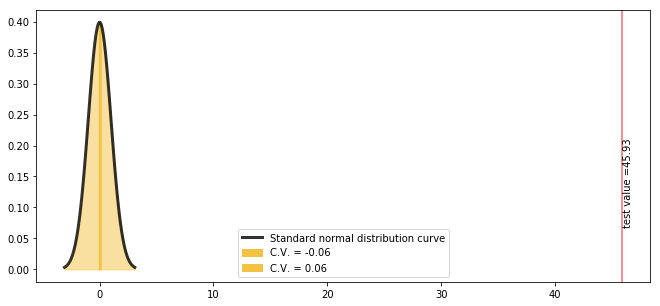


4. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that there is a significant relationship between x and y with a significance level of 0.05.

Although there is a significant relationship between x and y, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.


In [131]:
model = generate_multiple_linear_regression_model(
    df=df_student_grades,
    y='score',
    x1='gpa',
    x2='age',
)
print('F =', calculate_ftest(model))

compute_hypothesis_test_for_correlation_coefficient_multiple(
    model,
    n=5,
    k=2,
    significance_level=.05,
    ddof=2,
    show_chart=True,
)

### R²

#### Definitions

**Coefficient of multiple determination:** the amount of variation explained by the regression model.

**Error of residual variation:** 1-R², the amount of unexplained variation.


### Adjusted R²

#### Explaination
It is used because the value of R² is dependent on n (number of data points) and k (number of variables), and we want to consider the number of degrees of freedom.

When n ≈ k, value of R may be artificially inflated due to sampling error rather than true relationship among the variables. This occurs because the  chance variations of all the variables are used in conjunction with one another to derive the regression equation. Even if the individual correlation coefficients for each independent variable (x) and the dependent variable (y) were all zeo, the multiple correlation coefficient could be higher than 0 due to sampling error.

**Hence, we report both R² and R²adj**.

#### Rule
Adjusted R² < R²

#### Formula

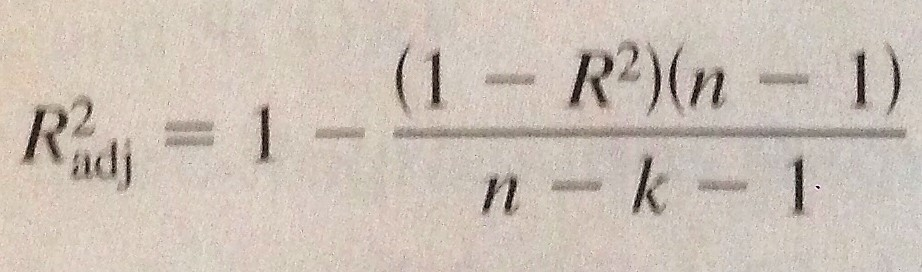